# **Import Libraries**

In [93]:
import os
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import stats
from scipy.spatial import distance
from output_analysis import load_data, compare_loop, get_predicted_classes
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json 

os.chdir("C:/Users/Damian/Documents/School/Winter 2023 - Grad School/IFT 6164 - Adversarial Learning/Project/StyleGAN_pytorch")

# **Import Data**

In [102]:

f = open('status.json')
data = json.loads(f.read()) #dist_type, ref_type, attack_type, strict)
type = data["dist_type"] # cosine, l2, wasserstein
ref_type = data["ref_type"] # avg median
attack_type = data["attack_type"]
strict = data["strict"]

fgsm_type = "out_"+attack_type+"/"
dir_prefix = "charts/"
clean_lst, clean_labels = load_data("out_test/")
adv_lst, adv_labels = load_data(fgsm_type)

if strict:
    avg_vec_lst = np.load("results/avg_vec_"+type+"_"+ref_type+".npy")
    dist_from_strict_avg_lst_clean = np.load("results/"+attack_type+"_std_strict_comp_per_class_clean_"+type+"_"+ref_type+".npy")
    dist_from_strict_avg_lst_adv = np.load("results/"+attack_type+"_std_strict_comp_per_class_adv_"+type+"_"+ref_type+".npy")
    strict_pred_class_dist = np.load("results/"+attack_type+"_strict_dist_of_predicted_class_per_class_"+type+"_"+ref_type+".npy", allow_pickle=True)

else:
    svm_results = np.load("results/svm_results_trainlst.npy")
    std_comp_per_class_clean = np.load("results/"+attack_type+"_std_comp_per_class_clean_"+type+"_"+ref_type+".npy")
    std_comp_per_class_adv = np.load("results/"+attack_type+"_std_comp_per_class_adv_"+type+"_"+ref_type+".npy")
    #closest_clean_vec = np.load("results/closest_clean_vec_"+type+".npy")
    #advec_in_class = np.load("results/advec_in_class_"+type+".npy")
    pred_class_dist = np.load("results/"+attack_type+"_dist_of_predicted_class_per_class_"+type+"_"+ref_type+".npy", allow_pickle=True)
    svm_model = pickle.load(open("results/svm_model.pickle", "rb"))

label_lst = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
if strict:
    strict_dict = {"clean": ("Clean", dist_from_strict_avg_lst_clean), "adv": ("Adversarial", dist_from_strict_avg_lst_adv)}
else:
    set_dict = {"clean": ("Clean", std_comp_per_class_clean), "adv": ("Adversarial", std_comp_per_class_adv)}
    
set_type_dict = {"cosine": "Cosine", "l2": "L2", "wasserstein": "Wasserstein"}
ref_type_dict = {"avg": "Average", "median":"Median"}

print("Attack Type: "+attack_type+" Stict: "+str(strict))

Attack Type: fgsm_01_cnn Stict: False


# **Plot Standard Deviation of Latent Space Vectors**

In [99]:
def plot_chart(data_dict):
    rows = 4
    cols = 3
    total_plots = 10
    figure, axis = plt.subplots(rows, cols, figsize = (20,20))
    figure.tight_layout(pad=4)
    # figure.suptitle("Standard Deviation from the "+ref_type_dict[ref_type]+" for Latent Space Vectors based on "+set_type_dict[type]+" Distance", fontsize=16)
    figure.subplots_adjust(top=.95)
    X = np.array([0,.5, 1, 1.5, 2, 2.5, 3])
    xtick_lst = ["0:0.5", "0.5:1.0", "1.0:1.5", "1.5:2.0", "2.0:2.5", "2.5:3.0", "3+"]
    index = 0
    bar_width = 0.2
    for i in range(rows):
        for j in range (cols):
            axis[i, j].bar(X-bar_width/2, data_dict["clean"][1][index], bar_width, color='b', label="Clean")
            axis[i, j].bar(X+bar_width/2, data_dict["adv"][1][index], bar_width, color='g', label="Adversarial")
            axis[i, j].set_title(label_lst[index])
            axis[i, j].set_xlabel("Standard Deviation")
            axis[i, j].set_ylabel("Vector Count")
            axis[i, j].set_xticks(X,xtick_lst)
            axis[i, j].legend(loc="best")
            index+=1
            if(index == total_plots):
                break
    figure.delaxes(axis[3][1])
    figure.delaxes(axis[3][2])

    if os.path.exists(dir_prefix+fgsm_type):
        plt.savefig(dir_prefix+fgsm_type+ref_type_dict[ref_type]+"_"+set_type_dict[type]+"_strict="+str(strict)+".png")
    else:
        os.makedirs(dir_prefix+fgsm_type)
        plt.savefig(dir_prefix+fgsm_type+ref_type_dict[ref_type]+"_"+set_type_dict[type]+"_strict="+str(strict)+".png")

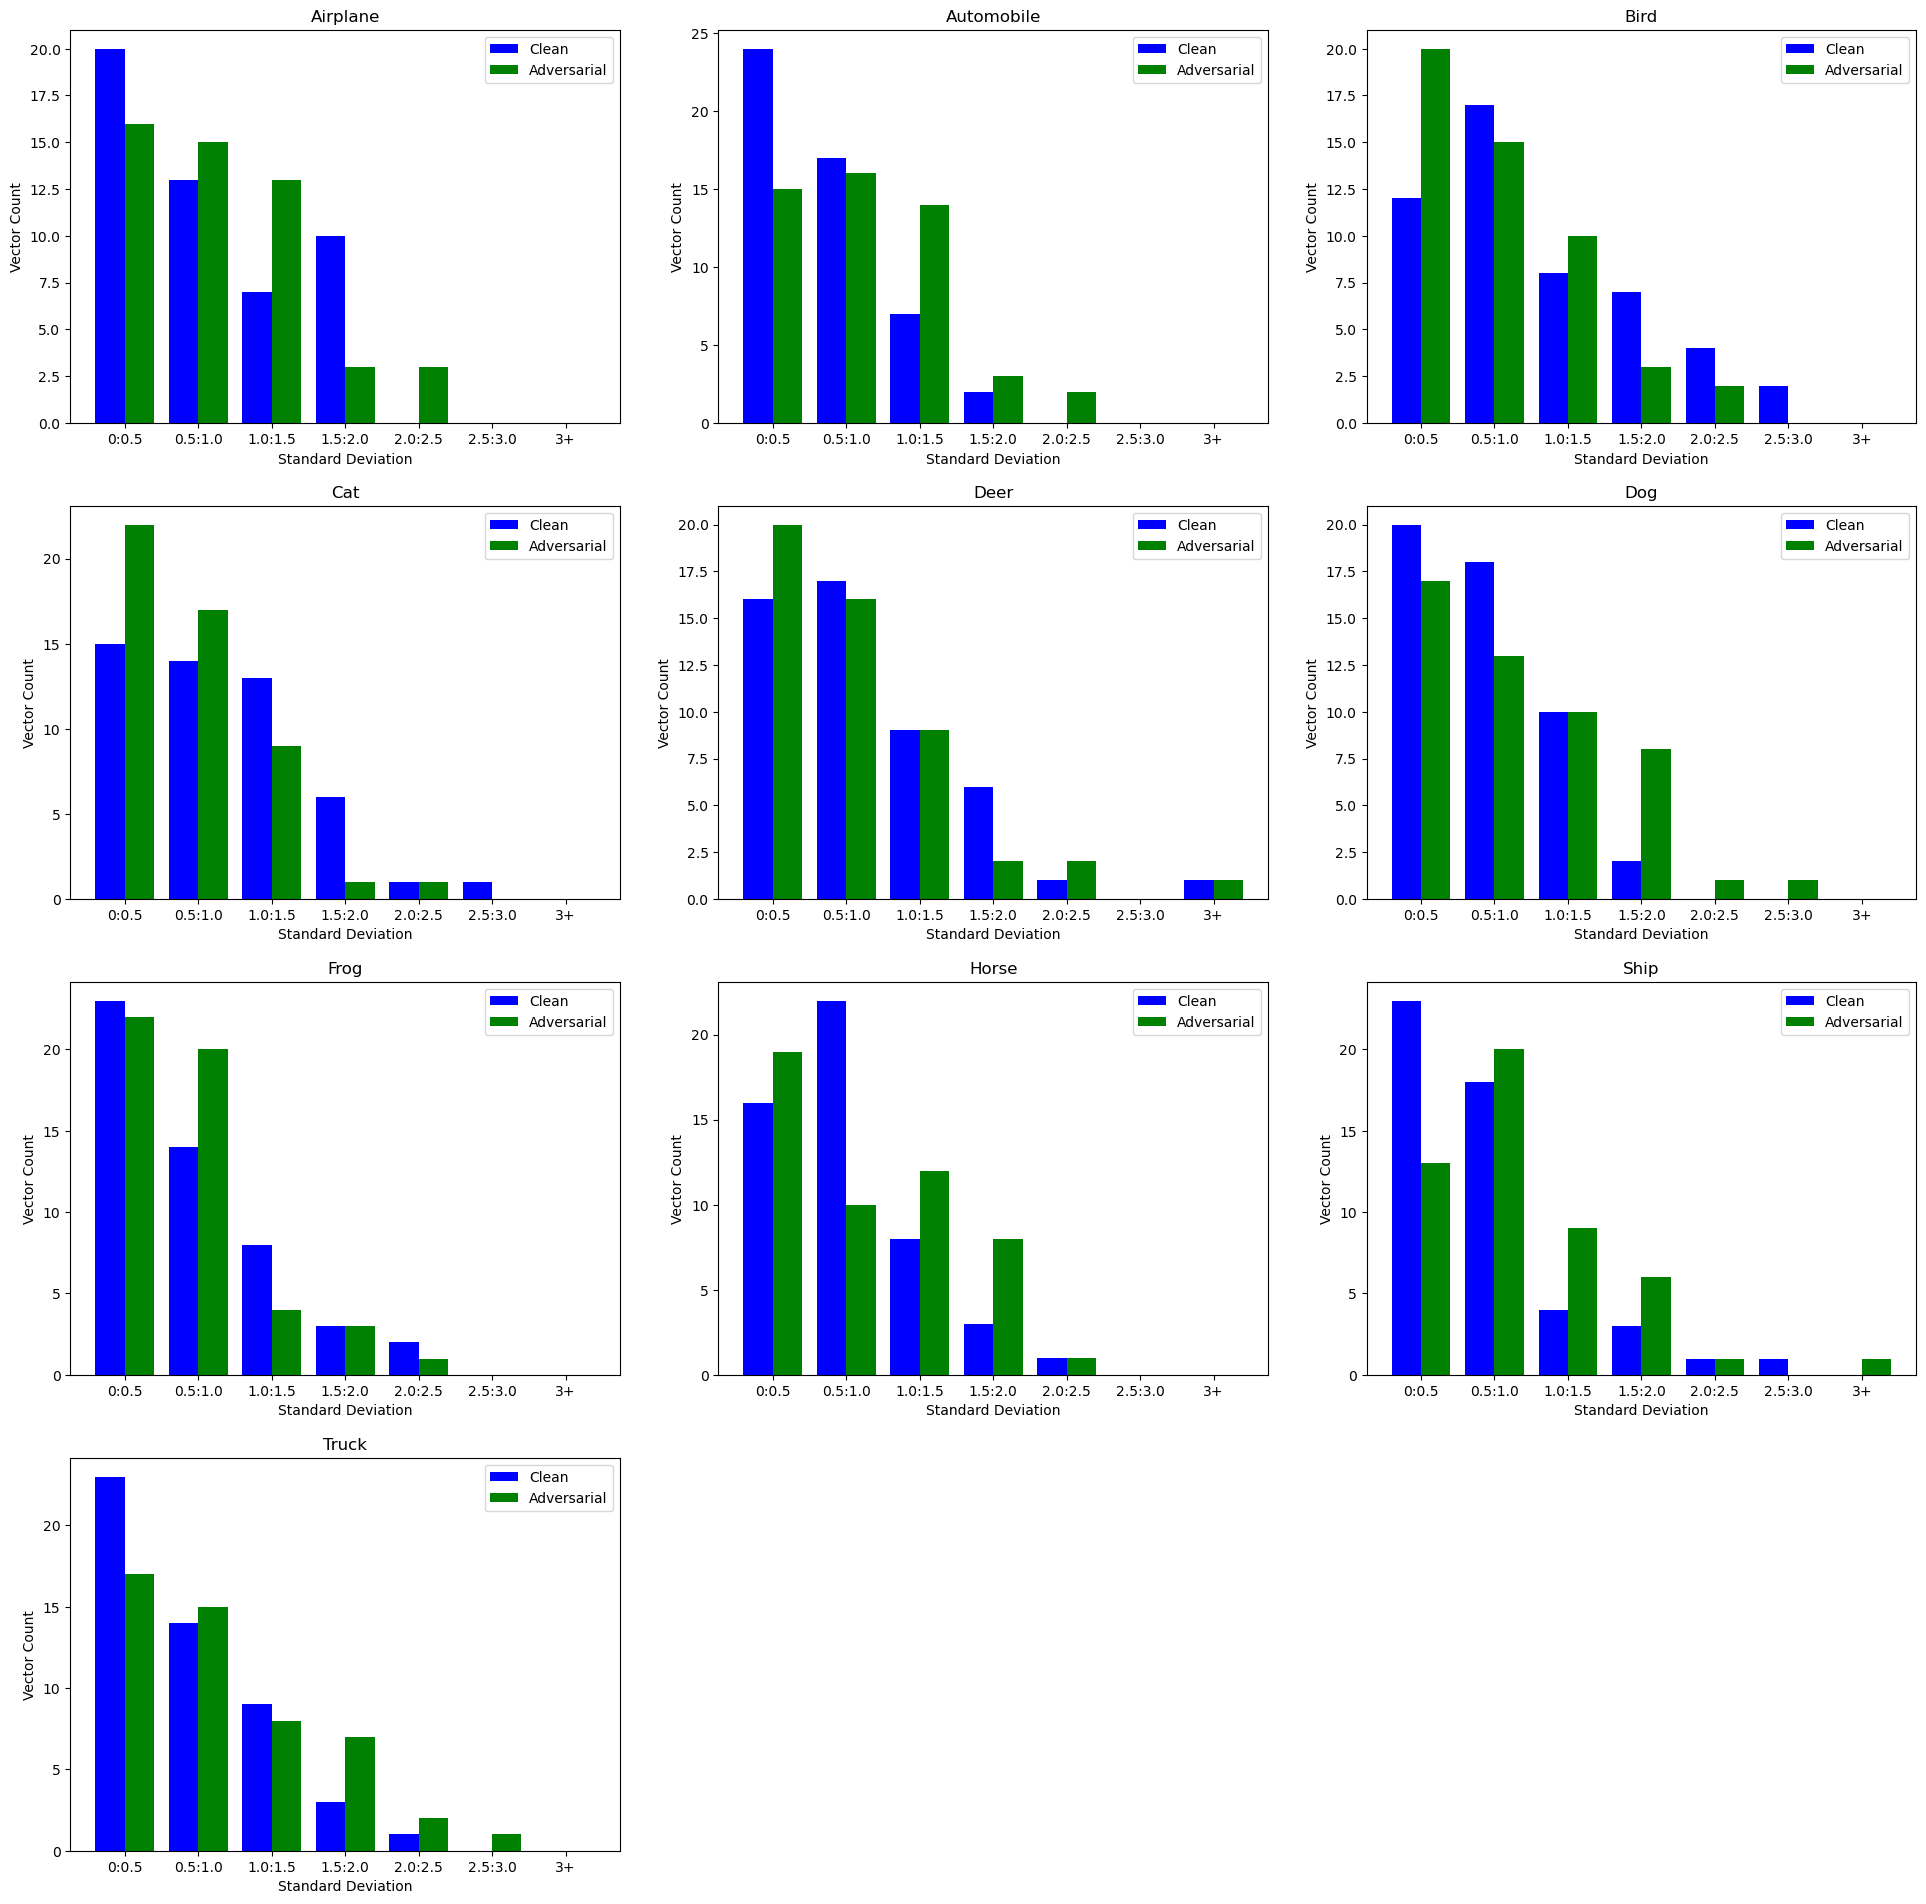

In [103]:
# input: set_dict or strict_dict
if strict:
    plot_chart(strict_dict)
else:
    plot_chart(set_dict)

# **Distance from Average Vector of Predicted Class**

In [245]:
def single_plot_all_class():
    count = compare_loop(pred_class_dist)
    plt.title("Adv. Vector Distance from Avg. Vector of Predicted Class", fontsize=16)
    plt.subplots_adjust(top=.95)
    X = np.array([0,.5, 1, 1.5, 2, 2.5, 3])
    xtick_lst = ["0:0.5", "0.5:1.0", "1.0:1.5", "1.5:2.0", "2.0:2.5", "2.5:3.0", "3+"]
    bar_width = 0.4
    plt.bar(X, count , bar_width, color='b')
    plt.xlabel("Standard Deviation")
    plt.ylabel("Vector Count")
    plt.xticks(X,xtick_lst)

In [71]:
def multi_plot_each_class(pred_dict, clean_dict):
    rows = 4
    cols = 3
    total_plots = 10
    figure, axis = plt.subplots(rows, cols, figsize = (20,20))
    figure.tight_layout(pad=4)
    # figure.suptitle("Adv. Vector Distance from "+ref_type_dict[ref_type]+" Vector of Predicted Class "+set_type_dict[type]+" Distance", fontsize=16)
    figure.subplots_adjust(top=.95)
    X = np.array([0,.5, 1, 1.5, 2, 2.5, 3])
    xtick_lst = ["0:0.5", "0.5:1.0", "1.0:1.5", "1.5:2.0", "2.0:2.5", "2.5:3.0", "3+"]
    index = 0
    bar_width = 0.2
    for i in range(rows):
        for j in range (cols):
            count = compare_loop(pred_dict[index])
            axis[i, j].bar(X-bar_width/2, clean_dict[index], bar_width, color='b', label="Clean")
            axis[i, j].bar(X+bar_width/2, count, bar_width, color='g', label="Adversarial")
            axis[i, j].set_title("Predicted Class: "+label_lst[index])
            axis[i, j].set_xlabel("Standard Deviation from Average Vec. of Pred. Class")
            axis[i, j].set_ylabel("Vector Count")
            axis[i, j].set_xticks(X,xtick_lst)
            axis[i, j].legend(loc="best")
            index+=1
            if(index == total_plots):
                break
    figure.delaxes(axis[3][1])
    figure.delaxes(axis[3][2])
    if os.path.exists(dir_prefix+fgsm_type):
        plt.savefig(dir_prefix+fgsm_type+ref_type_dict[ref_type]+"_"+set_type_dict[type]+"_from_pred"+"_strict="+str(strict)+".png")
    else:
        os.makedirs(dir_prefix+fgsm_type)
        plt.savefig(dir_prefix+fgsm_type+ref_type_dict[ref_type]+"_"+set_type_dict[type]+"_from_pred"+"_strict="+str(strict)+".png")

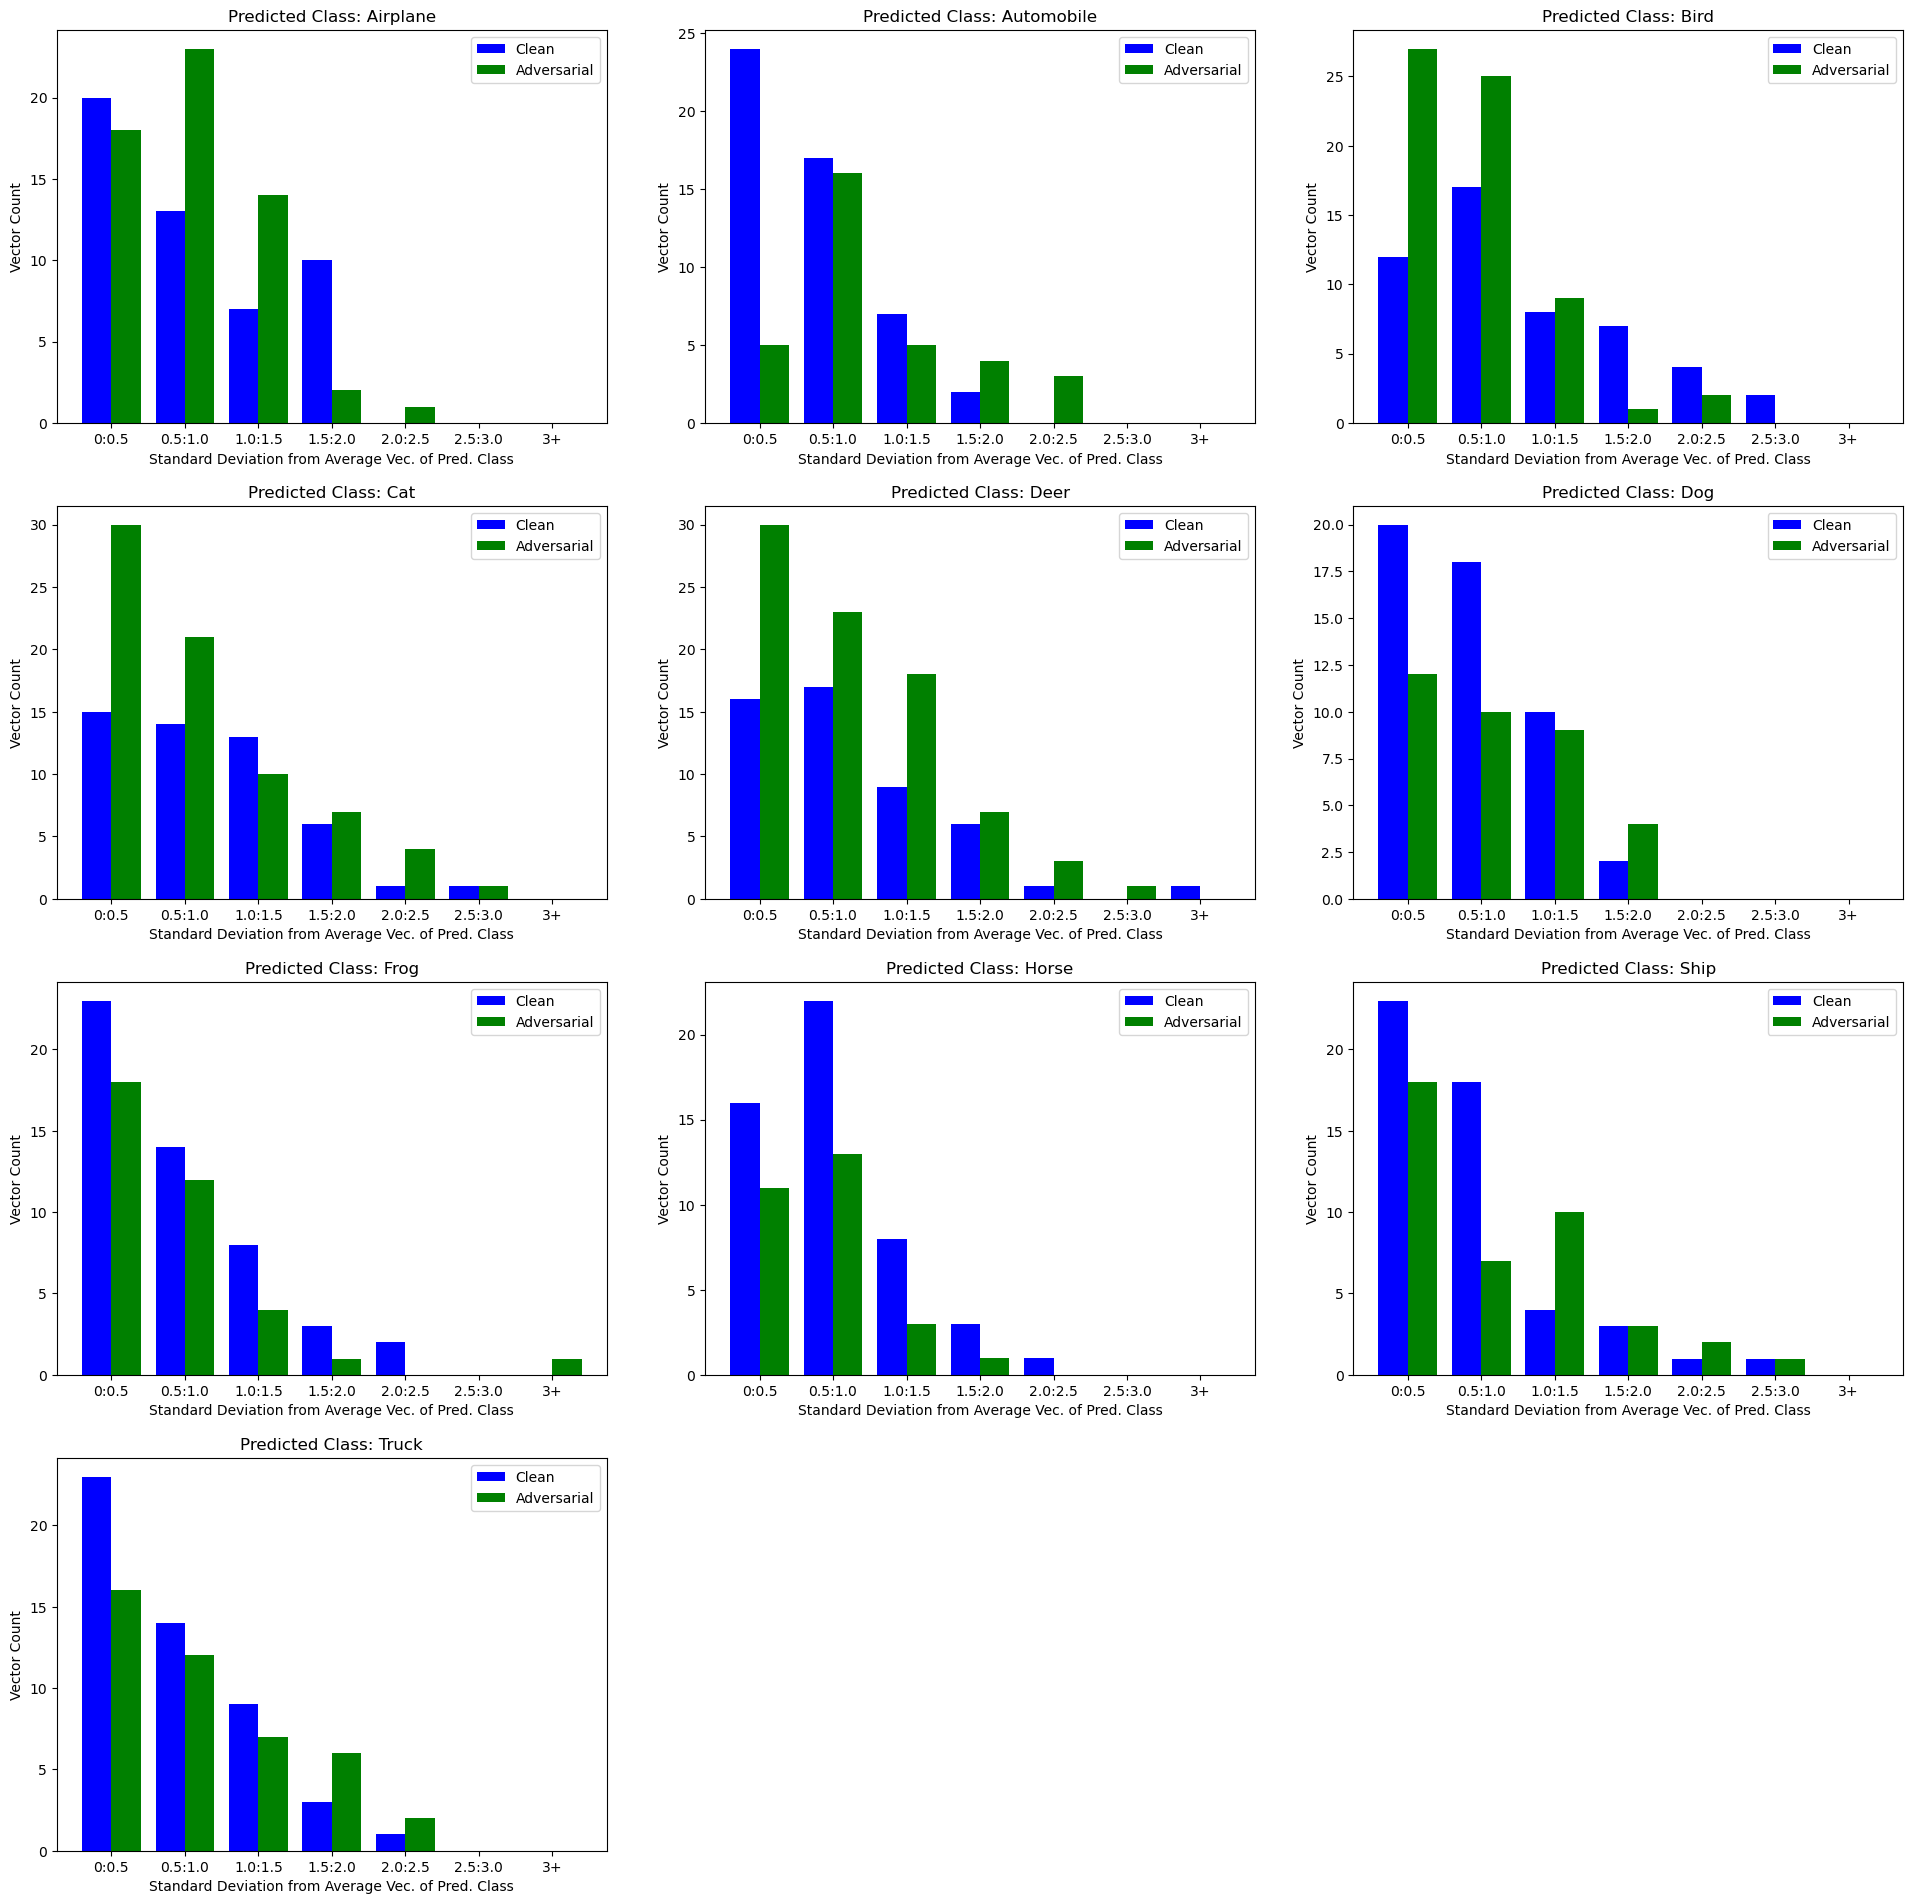

In [104]:
# pred_class_dist/strict_pred_class_dist vs. std_comp_per_class_clean
if strict:
    multi_plot_each_class(strict_pred_class_dist, dist_from_strict_avg_lst_clean)
else:
    multi_plot_each_class(pred_class_dist, std_comp_per_class_clean)

# **SVM Confusion Matrix**

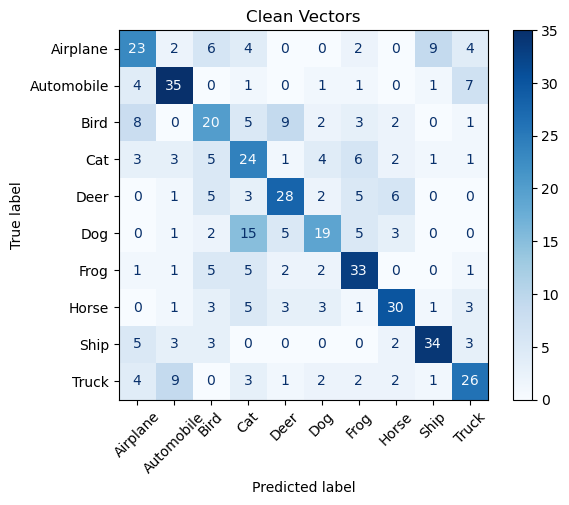

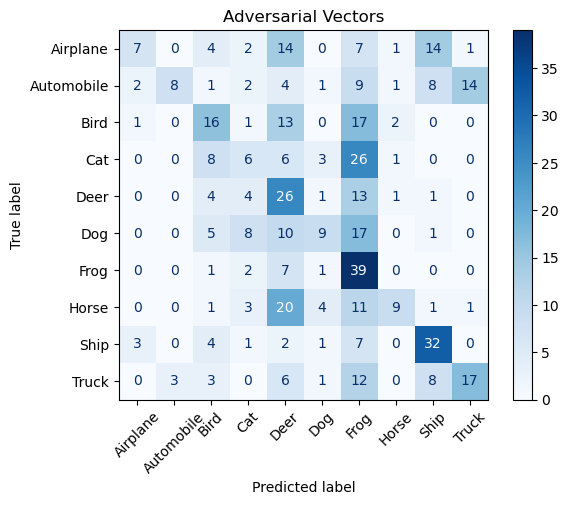

In [62]:
titles_options = [("Clean Vectors", clean_lst, clean_labels), ("Adversarial Vectors", adv_lst, adv_labels)]
for title, test_set, test_labels in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm_model,
        test_set,
        test_labels,
        display_labels=label_lst,
        cmap=plt.cm.Blues #, normalize=normalize,
    )
    disp.ax_.set_title(title)
    disp.ax_.set_xticks(np.arange(len(label_lst)), label_lst, rotation=45)
    if os.path.exists(dir_prefix+fgsm_type):
        plt.savefig(dir_prefix+fgsm_type+"_"+title+"_svm_confusion_matrix.png")
    else:
        os.makedirs(dir_prefix+fgsm_type)
        plt.savefig(dir_prefix+fgsm_type+"_"+title+"_svm_confusion_matrix.png")


# **Oracle Confusion Matrix**

sces


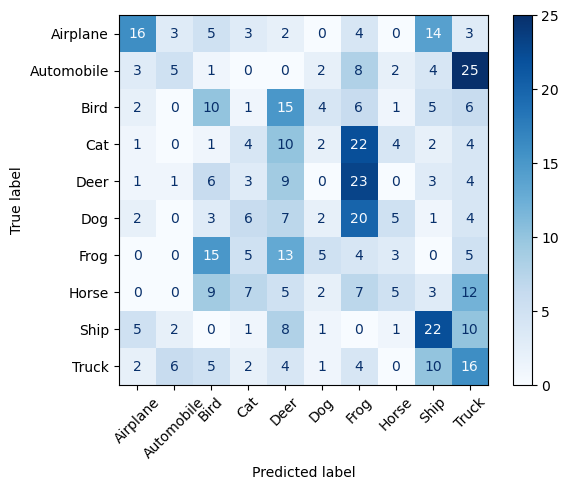

In [35]:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck = [0]*50, [1]*50, [2]*50, [3]*50, [4]*50, [5]*50, [6]*50, [7]*50, [8]*50, [9]*50
actual = airplane+ automobile + bird + cat + deer + dog + frog + horse + ship + truck

predicted = get_predicted_classes(attack_type) # attack_type: subs_fgsm_01, sces, spes, 
cm = confusion_matrix(actual, predicted)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_lst)

print(attack_type)
cm_display.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.show()